---

# 線形回帰
ここからは，線形回帰の問題について，もっと詳しく説明していきます．  
<br>

まず，回帰には
- 単回帰
- 重回帰

の2種類が存在し，これらを合わせて
- 線形回帰

と呼びます．



---

## 問題設定
今回は，「ボストン・データセット」と呼ばれるデータセットを使用します．

In [ ]:
# 学習用データ準備

from sklearn.datasets import load_boston

# データ読み込み
boston = load_boston()

# 入力データと正解データ取得
x_org, yt = boston.data, boston.target

# 各項目名リスト取得
feature_names = boston.feature_names

print("元データ", x_org.shape, yt.shape)
print("項目名", feature_names)

# データ絞り込み（項目RM（平均部屋数）のみを抽出する）
x = x_org[:, feature_names == "RM"]
print("絞り込み後", x.shape)
print(x[:5, :])

print("正解データ")
print(yt[:5])

元データ (506, 13) (506,)
項目名 ['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']
絞り込み後 (506, 1)
[[6.575]
 [6.421]
 [7.185]
 [6.998]
 [7.147]]
正解データ
[24.  21.6 34.7 33.4 36.2]


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.


---

## 単回帰
単回帰とは
- 1入力，1出力（ここで，入力は「説明変数」，出力は「目的変数」と呼ばれます）

の回帰問題のことであり，正確には「線形単回帰」と呼びます．  
<br>

今回は，説明変数にあたる入力を「平均部屋数」，目的変数にあたる出力を「不動産価格」として，これらの関係性を調べます．

<br>

最初に，予測関数を定義します．  
前章では，予測関数を以下のように定義しました．
```
# 予測関数
def pred(X):
    return W*X +B
```

今回は，クラスを使用して予測関数を定義します．ここで，予測関数は一般に
- モデル

と呼ばれます．

ここで，下記コードの重要な部分を説明すると
- クラスの親クラスに`torch.nn.Module`を指定します（親クラスに`torch.nn.Module`を指定することで，以降でも説明する様々な便利な機能を使用することができます）．
- クラスの内部には，`forward関数`が定義されており，この関数内で予測処理を実施します．

In [ ]:
import torch
class Net(torch.nn.Module):
    def __init__(self, n_input, n_output):
        # 親クラスnn.Moduleの初期化呼び出し
        super().__init__()

        # 出力層の定義
        self.l1 = torch.nn.Linear(n_input, n_output)

        # 初期値をすべて1にする
        torch.nn.init.constant_(self.l1.weight, 1.0)
        torch.nn.init.constant_(self.l1.bias, 1.0)

    # 予測関数の定義
    def forward(self, x):
        x1 = self.l1(x) # 線形回帰
        return x1        

PyTorchには，恒等関数 $ \mathrm{W*X+B}$ をはじめとして，ネットワークを構成する様々な関数が用意されており，下記関数
```
def pred(X):
    return W*X +B
```
の `W*X +B` にあたる部分はPyTorchでは
-  `torch.nn.Linear`

という名前で用意されています．  （[参考](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)：link先では $y=wx+b$ ではなく， $y = xA^\mathrm{T} + b$と表記されています．$A$ は，重み $w$ で構成された行列です）

今回は`torch.nn.Linear`のインスタンスを，`self.l1`という名前で定義し，`forward関数`で呼び出しています．

また，前章の予測関数は重みwとバイアスbの数が，下図のようにそれぞれ1つずつでした．

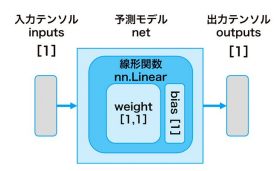

一方で，`torch.nn.Linear`を使用すると，下図のように入力と出力の重みwの数を指定できます．  
今回の場合，入力数を`n_input`，出力数を`n_output`としています．


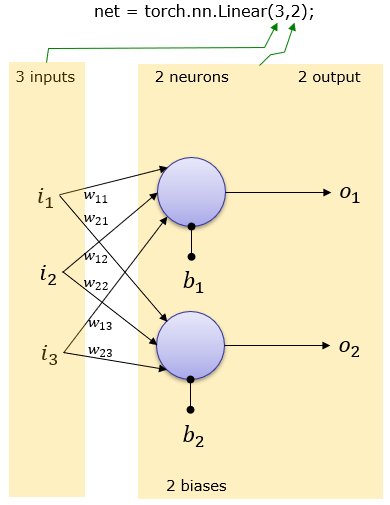

参考：https://www.sharetechnote.com/html/Python_PyTorch_nn_Linear_01.html

<br>

次に，定義した `Net` クラスを `net` という名前でインスタンス化します．

In [ ]:
# 変数定義
# 入力次元数
n_input = x.shape[1]

# 出力次元数
n_output = 1
print(f"入力次元数： {n_input} 出力次元数： {n_output}")

# 1入力，1出力の線形モデルを生成
net = Net(n_input, n_output)

入力次元数： 1 出力次元数： 1


<br>

ここで，Netクラスの親クラス`torch.nn.Module`で定義されている以下の関数を使用することでパラメータの情報を取得できます．
- `named_parameters`を使用することで，モデル内の変数名とその値を取得でき，
- `parameters`関数を使用すると，「パラメータ変数」のみが名前なしにリスト形式で返されます

In [ ]:
for parameter in net.named_parameters():
    print(f"変数名：{parameter[0]}")
    print(f"変数値：{parameter[1].data}")

print(" --------------- ")

for parameter in net.parameters():
    print(parameter)

変数名：l1.weight
変数値：tensor([[1.]])
変数名：l1.bias
変数値：tensor([1.])
 --------------- 
Parameter containing:
tensor([[1.]], requires_grad=True)
Parameter containing:
tensor([1.], requires_grad=True)


<br>

最後に，損失関数，最適化関数を用意します．  
損失関数は，前章では  
```
def mse(Yp, Y):
    loss = ((Yp - Y)**2).mean()
    return loss
```
といったように自分で定義していました．

`torch.nn.Linear` などと同様に，損失関数に関してもPyTorchで準備されています．  
今回使用する平均2乗誤差は
- `torch.nn.MSELoss`

という名前で実装されています．  

<br>

最適化関数に関しては，使用する関数は前章と同じですが，前章はパラメータが
```
optimizer = optim.SGD([W, B], lr=lr)
```
のようにWとBを直接指定していましたが，今回は，先ほど説明した `net.parameters()` を利用して最適化する対象のパラメータを指定しています．

In [ ]:
import torch.optim as optim
# 損失関数：平均2乗誤差
criterion = torch.nn.MSELoss()

# 学習率
lr = 0.01

# 最適化関数：勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

<br>

実際に学習する際は， `torch.nn.MSELoss()` のインスタンスである `criteriion` 関数を使用して
```
loss = criterion(outputs, labels1) # outputs:モデルから出力された予測値， label1：正解値
```
のように損失を計算するのですが，その際に
- 引数はN次元のベクトルではなく，（N,1）次元の行列形式

である必要があるため， `label1` をあらかじめ(N,1)次元に変換しておきます．


In [ ]:
labels = torch.tensor(yt).float() # 正解値yt

# 損失計算用に，labels変数を(N,1)次元の行列に変換
labels1 = labels.view((-1, 1))

# 次元確認
print(labels1.shape)

torch.Size([506, 1])


<br>
ここまでで準備が完了したので，実際に勾配を計算していくことにします．

### ①予測計算
先ほど作成したインスタンス化したモデル `net` に入力値 `inputs` を入力することで，予測値 `outputs` を得ることができます．

---
補足：  
これを具体的に言うと，`inputs` は，
```
class Net(torch.nn.Module):
    def __init__(self, n_input, n_output):
        # 親クラスnn.Moduleの初期化呼び出し
        super().__init__()

        # 出力層の定義
        self.l1 = torch.nn.Linear(n_input, n_output)

        # 初期値をすべて1にする
        torch.nn.init.constant_(self.l1.weight, 1.0)
        torch.nn.init.constant_(self.l1.bias, 1.0)

    # 予測関数の定義
    def forward(self, x):
        x1 = self.l1(x) # 線形回帰
        return x1   
```
内の

```
def forward(self, x):
    x1 = self.l1(x) # 線形回帰
    return x1 
```

の， `x` に引数として渡され，返り値 `x1` が `outputs` に代入されることになります．

---

In [ ]:
inputs = torch.tensor(x).float() # 入力
outputs = net(inputs) # 出力
print(outputs)

tensor([[7.5750],
        [7.4210],
        [8.1850],
        [7.9980],
        [8.1470],
        [7.4300],
        [7.0120],
        [7.1720],
        [6.6310],
        [7.0040],
        [7.3770],
        [7.0090],
        [6.8890],
        [6.9490],
        [7.0960],
        [6.8340],
        [6.9350],
        [6.9900],
        [6.4560],
        [6.7270],
        [6.5700],
        [6.9650],
        [7.1420],
        [6.8130],
        [6.9240],
        [6.5990],
        [6.8130],
        [7.0470],
        [7.4950],
        [7.6740],
        [6.7130],
        [7.0720],
        [6.9500],
        [6.7010],
        [7.0960],
        [6.9330],
        [6.8410],
        [6.8500],
        [6.9660],
        [7.5950],
        [8.0240],
        [7.7700],
        [7.1690],
        [7.2110],
        [7.0690],
        [6.6820],
        [6.7860],
        [7.0300],
        [6.3990],
        [6.6020],
        [6.9630],
        [7.1150],
        [7.5110],
        [6.9980],
        [6.8880],
        [8

### ②損失計算
予測結果 `outputs` と正解値 `label1` を引数にして損失関数から損失を計算します．

In [ ]:
# 損失の計算
loss = criterion(outputs, labels1)

print(f"{loss.item():.5f}")

308.44986


### ③勾配計算
勾配の計算は，backward関数を呼び出すだけでOKです．

In [ ]:
# 誤差の逆伝播
loss.backward()

### ④パラメータ修正
誤差逆伝播した結果を反映させるために，step関数でパラメータ（weight, bias）を修正します．  
backward関数は，呼び出されるたびに値が加算されるため，パラメータの修正が終わったら**勾配値の初期化を忘れずにしましょう．**

In [ ]:
# パラメータの修正
optimizer.step()

# 勾配値の初期化
optimizer.zero_grad()

### 繰り返し計算
これまでの①〜④の流れを繰り返し計算するように設定します． 

In [ ]:
import numpy as np
# 学習率
lr = 0.01

# インスタンス生成　(パラメータ値初期化)
net = Net(n_input, n_output)

# 損失関数： 平均2乗誤差
criterion = torch.nn.MSELoss()

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 50000

# 評価結果記録用 (損失関数値のみ記録)
history = np.zeros((0,2))
## ここまで初期設定 ------------------------

# 繰り返し計算メインループ

for epoch in range(num_epochs):
    
    # 勾配値初期化
    optimizer.zero_grad()

    # 予測計算
    outputs = net(inputs)
  
    # 損失計算
    # 「ディープラーニングの数学」に合わせて2で割った値を損失としています
    loss = criterion(outputs, labels1) / 2.0

    # 勾配計算
    loss.backward()

    # パラメータ修正
    optimizer.step()

    # 100回ごとに途中経過を記録する
    if ( epoch % 100 == 0):
        history = np.vstack((history, np.array([epoch, loss.item()])))
        print(f'Epoch {epoch} loss: {loss.item():.5f}')

Epoch 0 loss: 154.22493
Epoch 100 loss: 29.61752
Epoch 200 loss: 29.43177
Epoch 300 loss: 29.25043
Epoch 400 loss: 29.07340
Epoch 500 loss: 28.90058
Epoch 600 loss: 28.73186
Epoch 700 loss: 28.56716
Epoch 800 loss: 28.40636
Epoch 900 loss: 28.24939
Epoch 1000 loss: 28.09615
Epoch 1100 loss: 27.94654
Epoch 1200 loss: 27.80050
Epoch 1300 loss: 27.65792
Epoch 1400 loss: 27.51873
Epoch 1500 loss: 27.38285
Epoch 1600 loss: 27.25020
Epoch 1700 loss: 27.12070
Epoch 1800 loss: 26.99428
Epoch 1900 loss: 26.87086
Epoch 2000 loss: 26.75037
Epoch 2100 loss: 26.63275
Epoch 2200 loss: 26.51792
Epoch 2300 loss: 26.40582
Epoch 2400 loss: 26.29638
Epoch 2500 loss: 26.18955
Epoch 2600 loss: 26.08525
Epoch 2700 loss: 25.98343
Epoch 2800 loss: 25.88404
Epoch 2900 loss: 25.78700
Epoch 3000 loss: 25.69227
Epoch 3100 loss: 25.59979
Epoch 3200 loss: 25.50950
Epoch 3300 loss: 25.42137
Epoch 3400 loss: 25.33532
Epoch 3500 loss: 25.25132
Epoch 3600 loss: 25.16932
Epoch 3700 loss: 25.08927
Epoch 3800 loss: 25.011

### 結果の評価
学習曲線で結果を確認しましょう．

/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23398 (\N{CJK UNIFIED IDEOGRAPH-5B66}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32722 (\N{CJK UNIFIED IDEOGRAPH-7FD2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32218 (\N{CJK UNIFIED IDEOGRAPH-7DDA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25613 (\N{CJK UNIFIED IDEOGRAPH-640D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local

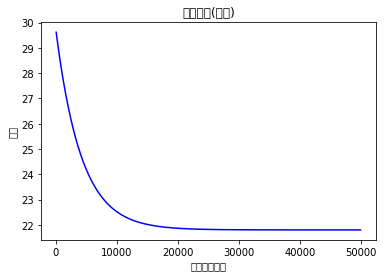

In [ ]:
import matplotlib.pyplot as plt
# 学習曲線の表示 (損失) 
# 最初の1つを除く

plt.plot(history[1:,0], history[1:,1], 'b')
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.title('学習曲線(損失)')
plt.show()

<br>
正しく学習できていることを確認できたと思うので，学習後のモデルから生成される1次関数のグラフを確認してみましょう．  

今回は，説明変数にあたる入力を「平均部屋数」，目的変数にあたる出力を「不動産価格」として学習していたので，グラフの結果より
- 平均部屋数が多い家ほど，不動産価格が高くなる傾向がある

という関係性がこのグラフから分かります．

[[-2.2188606]
 [45.21208  ]]


/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25955 (\N{CJK UNIFIED IDEOGRAPH-6563}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22259 (\N{CJK UNIFIED IDEOGRAPH-56F3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12392 (\N{HIRAGANA LETTER TO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24112 (\N{CJK UNIFIED IDEOGRAPH-5E30}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/pyt

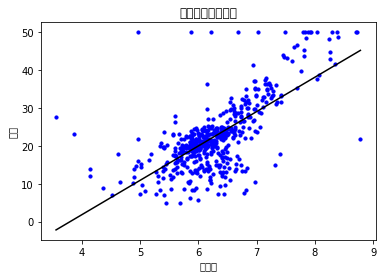

In [ ]:
# 回帰直線の算出
# xの最小値、最大値
xse = np.array((x.min(), x.max())).reshape(-1,1)
Xse = torch.tensor(xse).float()

with torch.no_grad():
  Yse = net(Xse)

print(Yse.numpy())

# 散布図と回帰直線の描画
plt.scatter(x, yt, s=10, c='b')
plt.xlabel('部屋数')
plt.ylabel('価格')
plt.plot(Xse.data, Yse.data, c='k')
plt.title('散布図と回帰直線')
plt.show()